In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

In [128]:
# Chemin vers votre fichier JSONL
file_path = './data/all.jsonl'

# Charger le fichier JSONL dans un DataFrame
df = pd.read_json(file_path, nrows=500, lines=True)

# Afficher les premières lignes du DataFrame pour vérifier
df.head()

,question,human_answers,chatgpt_answers,index,source
0,"Why is every book I hear about a "" NY Times # ...","[Basically there are many categories of "" Best...",[There are many different best seller lists th...,NaN,reddit_eli5
1,"If salt is so bad for cars , why do we use it ...",[salt is good for not dying in car crashes and...,[Salt is used on roads to help melt ice and sn...,NaN,reddit_eli5
2,Why do we still have SD TV channels when HD lo...,[The way it works is that old TV stations got ...,[There are a few reasons why we still have SD ...,NaN,reddit_eli5
3,Why has nobody assassinated Kim Jong - un He i...,[You ca n't just go around assassinating the l...,[It is generally not acceptable or ethical to ...,NaN,reddit_eli5
4,How was airplane technology able to advance so...,[Wanting to kill the shit out of Germans drive...,[After the Wright Brothers made the first powe...,NaN,reddit_eli5


In [129]:
df.shape

(500, 5)

In [130]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   question         500 non-null    object 
 1   human_answers    500 non-null    object 
 2   chatgpt_answers  500 non-null    object 
 3   index            0 non-null      float64
 4   source           500 non-null    object 
dtypes: float64(1), object(4)
memory usage: 19.7+ KB
None


In [131]:
import pandas as pd

# drop 'source' et 'index'
df = df.drop(['source', 'index'], axis=1)

human_df = df[['question', 'human_answers']].copy()
human_df = human_df.explode('human_answers')  # Séparer les réponses dans des lignes séparées
human_df.rename(columns={'human_answers': 'answers'}, inplace=True)
human_df['is_gpt'] = False

gpt_df = df[['question', 'chatgpt_answers']].copy()
gpt_df.rename(columns={'chatgpt_answers': 'answers'}, inplace=True)
gpt_df['is_gpt'] = True

# Concaténer les deux DataFrames
df = pd.concat([human_df, gpt_df], ignore_index=True)

# Supprimer la colonne 'question' si nécessaire
df = df.drop(['question'], axis=1)

# Afficher les premières lignes du DataFrame final
df.head()


,answers,is_gpt
0,"Basically there are many categories of "" Best ...",False
1,"If you 're hearing about it , it 's because it...",False
2,"One reason is lots of catagories . However , h...",False
3,salt is good for not dying in car crashes and ...,False
4,"In Minnesota and North Dakota , they tend to u...",False


In [132]:
df.shape

(2000, 2)

<Axes: xlabel='is_gpt', ylabel='count'>

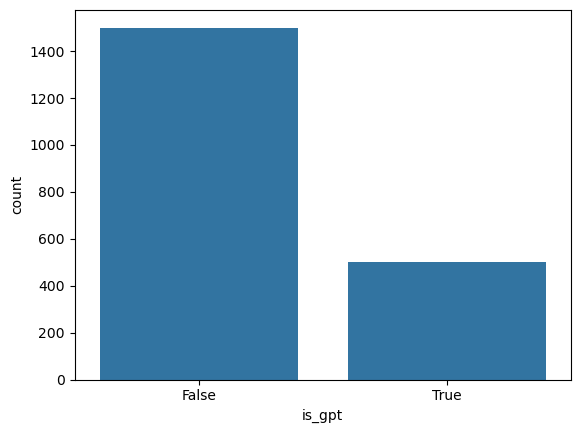

In [133]:
sns.countplot(x=df['is_gpt'])

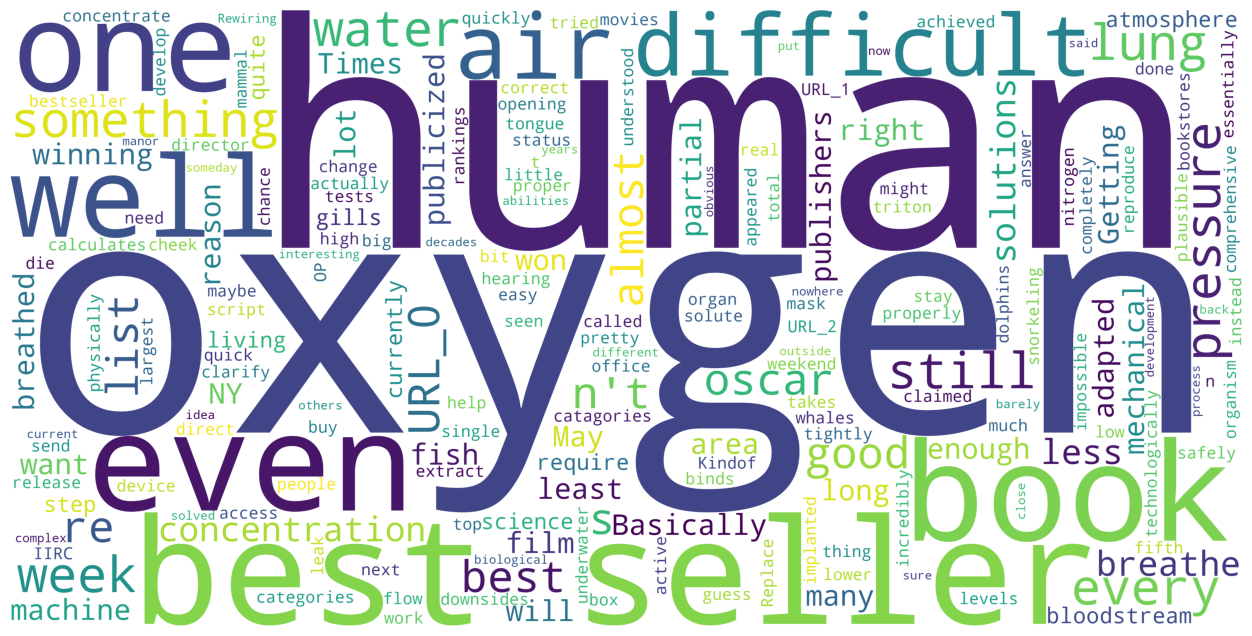

In [134]:
# word cloud human answers
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['is_gpt'] == False]
action_text = human['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

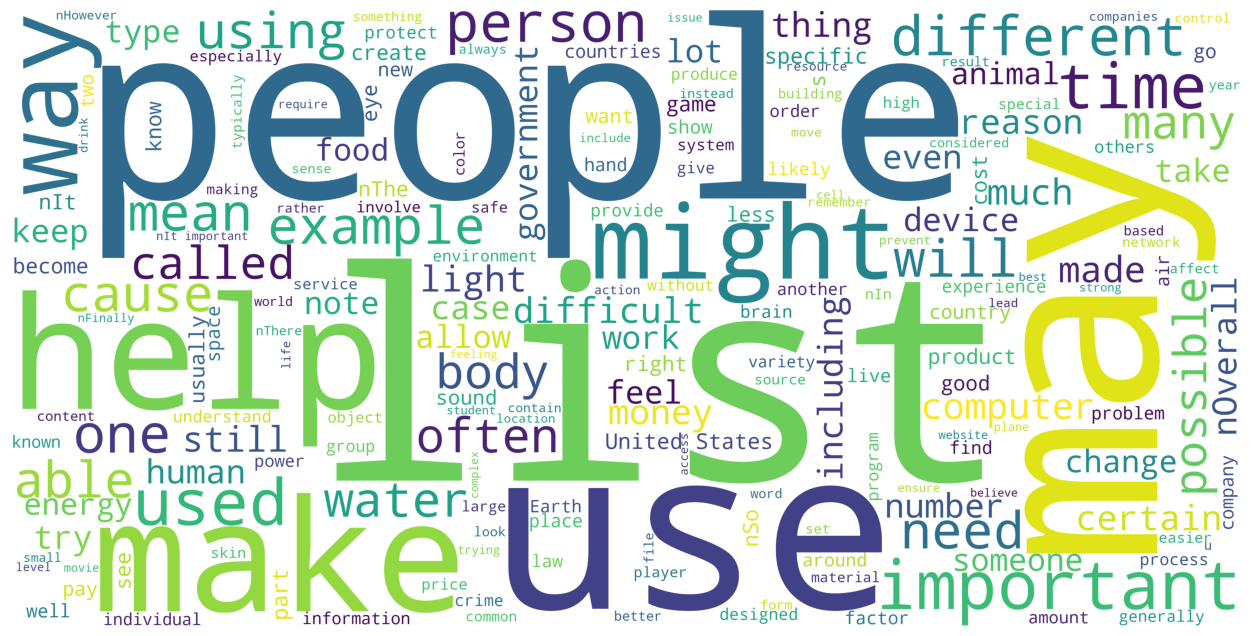

In [135]:
# word cloud GPT answers
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)
human = df[df['is_gpt'] == True]
action_text = human['answers'].values
wordcloud = WordCloud(stopwords=stopwords, background_color='white', height=2000, width=4000).generate(str(action_text))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [136]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42,stratify=df['is_gpt'])